## Set up Workspace

### Steps

1. Read in an explore data
2. Regrid to 0.25 deg Lat-Lon grid
3. Alignepochs.R-esque function to get moving windows
4. biascorrection.R-esque function for Z-score correction of _ward wind
5. Save file
6. Compare to corrected historical and rcp85 model

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import interpolate
import xesmf as xe
import pandas as pd
from calendar import isleap
from dateutil import relativedelta as rd
from datetime import datetime, timedelta
import cftime
import intake
import yaml
import pandas as pd
from intake_esm import config
from distributed.utils import format_bytes

/glade/u/home/jkent/miniconda3/envs/pangeo/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
import sys
print(sys.executable)

/glade/u/home/jkent/miniconda3/envs/pangeo/bin/python


In [3]:
%matplotlib inline

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Look at Data

In [4]:
config.get('collections.cordex')

test = yaml.safe_load('''name: NA-CORDEX
collection_type: cordex
data_sources:
  CORDEX-Data:
    locations:
      - name: GLADE
        loc_type: posix
        direct_access: True
        urlpath: /glade/collections/cdg/data/cordex/data/''')        

col = intake.open_esm_metadatastore(collection_input_definition=test, overwrite_existing=True)

Getting file listing: CORDEX-Data:GLADE:posix:/glade/collections/cdg/data/cordex/data/



<class 'pandas.core.frame.DataFrame'>
Int64Index: 16897 entries, 14130 to 11851
Data columns (total 13 columns):
resource                  16897 non-null object
resource_type             16897 non-null object
direct_access             16897 non-null bool
variable                  16897 non-null object
experiment                16897 non-null object
global_climate_model      16897 non-null object
regional_climate_model    16897 non-null object
frequency                 16897 non-null object
grid                      16897 non-null object
bias_corrected_or_raw     16897 non-null object
file_fullpath             16897 non-null object
file_basename             16897 non-null object
file_dirname              16897 non-null object
dtypes: bool(1), object(12)
memory usage: 1.7+ MB
None
Persisting NA-CORDEX at : /glade/u/home/jkent/.intake_esm/collections/cordex/NA-CORDEX.cordex.csv


In [5]:
query = col.search(variable='uas', global_climate_model = 'CanESM2', experiment = ['hist', 'rcp85'], regional_climate_model = 'CRCM5-UQAM', frequency = 'day', grid = 'NAM-44i', bias_corrected_or_raw = 'raw')
query.query_results.head()

,resource,resource_type,direct_access,variable,experiment,global_climate_model,regional_climate_model,frequency,grid,bias_corrected_or_raw,file_fullpath,file_basename,file_dirname
10661,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,uas,hist,CanESM2,CRCM5-UQAM,day,NAM-44i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...
10676,CORDEX-Data:GLADE:posix:/glade/collections/cdg...,posix,True,uas,rcp85,CanESM2,CRCM5-UQAM,day,NAM-44i,raw,/glade/collections/cdg/data/cordex/data/raw/NA...,uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc,/glade/collections/cdg/data/cordex/data/raw/NA...


In [6]:
dset = query.to_xarray(chunks = {'lon':100})

In [7]:
modeled = dset['CanESM2.CRCM5-UQAM.day.NAM-44i.raw']

In [11]:
modeled.time

<xarray.DataArray 'time' (time: 55114)>
array([cftime.DatetimeNoLeap(1950, 1, 1, 12, 0, 0, 0, 4, 1),
       cftime.DatetimeNoLeap(1950, 1, 2, 12, 0, 0, 0, 5, 2),
       cftime.DatetimeNoLeap(1950, 1, 3, 12, 0, 0, 0, 6, 3), ...,
       cftime.DatetimeNoLeap(2100, 12, 28, 12, 0, 0, 0, 4, 362),
       cftime.DatetimeNoLeap(2100, 12, 29, 12, 0, 0, 0, 5, 363),
       cftime.DatetimeNoLeap(2100, 12, 30, 12, 0, 0, 0, 6, 364)], dtype=object)
Coordinates:
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-30 12:00:00
Attributes:
    coordinate_defines:  point
    bounds:              time_bnds
    delta_t:             0000-00-01 00:00:00
    axis:                T
    standard_name:       time
    long_name:           time

In [12]:
#Measured Data still not supported by intake-esm

path = '../../kddm/data/uas/'
measured = xr.open_dataset(path+'uas.METDATA.44i.nc', chunks = {'time':5})
#hist = xr.open_dataset(path+'uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc', chunks = {'time':5})
#rcp85 = xr.open_dataset(path+'uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc', chunks = {'time':5})

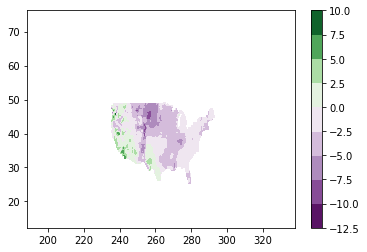

In [13]:
plt.contourf(measured.lon, measured.lat, measured.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

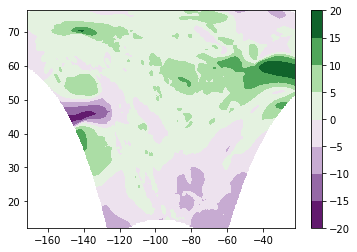

In [14]:
plt.contourf(modeled.lon, modeled.lat, modeled.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

## Filter and Regrid Data to Quarter Degree Grid

In [15]:
measured_droplats = measured.dropna(dim='lat', how ='all')
measured_flt = measured_droplats.dropna(dim='lon', how='all')

In [16]:
lon_min = float(np.min(measured_flt.lon))
lon_max = float(np.max(measured_flt.lon))
lat_min = float(np.min(measured_flt.lat))
lat_max = float(np.max(measured_flt.lat))
wesn = [lon_min, lon_max, lat_min, lat_max]

In [17]:
grid = 0.25
wesn_g = [int(round(i * 4)) / 4 for i in wesn]

new_lon = np.arange(wesn_g[0],wesn_g[1], grid)
new_lat = np.arange(wesn_g[2], wesn_g[3]+grid, grid)

ds_newgrid = xr.Dataset({'lat': (['lat'], new_lat), 'lon': (['lon'], new_lon)})

In [18]:
regridder_measured = xe.Regridder(measured_flt, ds_newgrid, 'bilinear')
measured_rgrd = regridder_measured(measured_flt.uas)

Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.


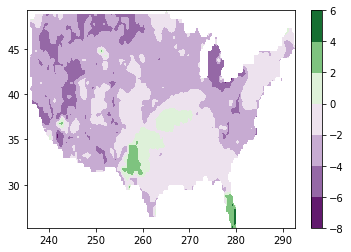

In [19]:
plt.contourf(measured_rgrd.lon, measured_rgrd.lat, measured_rgrd.isel(time=300), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [20]:
def force_pos_lon(ds):
    ds_poslon = ds.assign_coords(lon = ds.lon+ 360) if (np.min(ds.lon) < 0) else ds
    return ds_poslon

def regrid_model_coords(ds, wesn, newgrid):
    ds_poslon = force_pos_lon(ds)
    ds_flt = ds_poslon.sel(lon = slice(wesn[0], wesn[1]),lat = slice(wesn[2], wesn[3]))
    regridder_ds = xe.Regridder(ds_flt, newgrid, 'bilinear')
    ds_rgrd = regridder_ds(ds_flt.uas)
    return ds_rgrd

In [21]:
modeled_rgrd = regrid_model_coords(modeled, wesn, ds_newgrid)

Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.


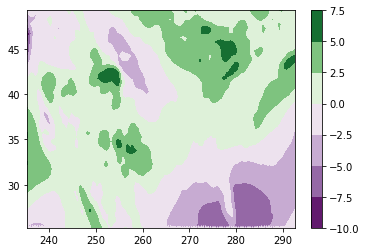

In [22]:
plt.contourf(modeled_rgrd.lon, modeled_rgrd.lat, modeled_rgrd.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [23]:
#Put NaN's where there is always NaN in measured

## Align Time

In [27]:
modeled_rgrd.time.encoding
#Why is this empty??

{}

In [28]:
def check_calendars(da_measured, da_modeled):
    cal_measured = da_measured.time.encoding['calendar']
    cal_modeled = da_modeled.time.encoding['calendar']
    return cal_measured, cal_modeled

#cal_measured, cal_modeled = check_calendars(measured_rgrd, modeled_rgrd)  

In [29]:
modeled_rgrd.time

<xarray.DataArray 'time' (time: 55114)>
array([cftime.DatetimeNoLeap(1950, 1, 1, 12, 0, 0, 0, 4, 1),
       cftime.DatetimeNoLeap(1950, 1, 2, 12, 0, 0, 0, 5, 2),
       cftime.DatetimeNoLeap(1950, 1, 3, 12, 0, 0, 0, 6, 3), ...,
       cftime.DatetimeNoLeap(2100, 12, 28, 12, 0, 0, 0, 4, 362),
       cftime.DatetimeNoLeap(2100, 12, 29, 12, 0, 0, 0, 5, 363),
       cftime.DatetimeNoLeap(2100, 12, 30, 12, 0, 0, 0, 6, 364)], dtype=object)
Coordinates:
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-30 12:00:00
Attributes:
    coordinate_defines:  point
    bounds:              time_bnds
    delta_t:             0000-00-01 00:00:00
    axis:                T
    standard_name:       time
    long_name:           time

In [30]:
def cfnoleap_to_datetime(da):
    datetimeindex = da.indexes['time'].to_datetimeindex()
    ds = da.to_dataset()
    ds['time_dt']= ('time', datetimeindex)
    ds = ds.swap_dims({'time': 'time_dt'})
    assert len(da.time) == len(ds.time_dt)
    return ds

#Add a check here that uses info from checking the calendars?
ds_modeled_dt = cfnoleap_to_datetime(modeled_rgrd)

/glade/u/home/jkent/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [31]:
def regroup_models_bytime(da_measured, ds_modeled):
    t0_measured = da_measured.time[0]
    t_last_measured = da_measured.time[-1]
    t0_fut = t_last_measured.values + np.timedelta64(1, 'D')
    
    ds_hist = ds_modeled.sel(time_dt = slice(t0_measured, t_last_measured))
    ds_fut = ds_modeled.sel(time_dt = slice(t0_fut,None))
    return ds_hist, ds_fut

ds_hist, ds_fut = regroup_models_bytime(measured_rgrd, ds_modeled_dt)

In [32]:
def cal_interpolate(da_measured, ds_hist):
    years = da_measured.time.dt.year
    leap_bool = [isleap(y) for y in set(years.values)]

    da_measured_noleap = da_measured.interp(time = ds_hist.time_dt)
    da_measured_noleap.coords['time'] = ds_hist.time
    assert len(da_measured_noleap.time) - len(ds_hist.time_dt) == 0
    return da_measured_noleap

da_measured_noleap = cal_interpolate(measured_rgrd, ds_hist)

In [33]:
da_measured_swappedtime = da_measured_noleap.swap_dims({'time_dt':'time'})
ds_modeled_swappedtime = ds_hist.swap_dims({'time_dt':'time'})
ds_fut_swappedtime = ds_fut.swap_dims({'time_dt':'time'})

In [34]:
#Seth suggests subsampling instead of interpolating
#Interp okay for continuous variables
#Interp not good for spiky discontinuos variables (precipitation!)
#Make an align_calendars function that provides options, interpolation or subsampling randomly placed
#Print total amount of precipitation that was dropped in subsampling?

## Grouby Average for Every Day Across Years
#### (Dec 15 -> full 12 months -> Jan 15)

In [35]:
measured_avyear = da_measured_swappedtime.groupby('time.dayofyear').mean(dim='time')
model_avyear = ds_modeled_swappedtime.groupby('time.dayofyear').mean(dim='time')
fut_avyear = ds_fut_swappedtime.groupby('time.dayofyear').mean(dim='time')

/glade/u/home/jkent/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [36]:
def hack_circular_rolling(ds_avyear):
    last = ds_avyear.isel(dayofyear=slice(-15, None))
    last['dayofyear'] = np.arange(-15,0)
    
    first = ds_avyear.isel(dayofyear=slice(0, 15))
    first['dayofyear'] = np.arange(366,381)
    
    ds_circ = xr.concat([last, ds_avyear, first], 'dayofyear')
    return ds_circ;

measured_circ = hack_circular_rolling(measured_avyear)
past_circ = hack_circular_rolling(model_avyear)
fut_circ = hack_circular_rolling(fut_avyear)

## Z-Score Bias Correction Method

In [37]:
#Moving window
mv_window_w = 31

In [38]:
def get_stats(ds_avyear, ds_circ): 
    ds_mean = ds_circ.rolling(dayofyear=mv_window_w, center=True).mean()
    ds_mean = ds_mean.sel(dayofyear = slice(1, 365))

    ds_std = ds_circ.rolling(dayofyear=mv_window_w, center=True).std()
    ds_std = ds_std.sel(dayofyear = slice(1, 365))

    ds_zscore = (ds_avyear - ds_mean) / ds_std
    return ds_mean, ds_std, ds_zscore;

measured_mean, measured_std, measured_zscore = get_stats(measured_avyear, measured_circ)
model_mean, model_std, model_zscore = get_stats(model_avyear, past_circ)
fut_mean, fut_std, fut_zscore = get_stats(fut_avyear, fut_circ)

In [39]:
shift = measured_mean - model_mean
scale = measured_std - model_std

In [40]:
new_mean_past = model_mean + shift
new_std_past = model_std * scale

new_mean = fut_mean + shift
new_std = fut_std * scale

In [41]:
past_corrected = (model_zscore * new_std_past) + new_mean_past
fut_corrected = (fut_zscore * new_std) + new_mean